# Libraries

In [354]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_validate, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from imblearn.over_sampling import SMOTE
from scipy.stats.mstats import winsorize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score, precision_recall_curve, log_loss
import warnings
warnings.filterwarnings('ignore')

# Linear regression

## Generate synthetic data for linear regression

Create a function that generates a synthetic dataset for linear regression. The function should take the number of samples, the slope, the intercept, and noise as arguments, and return a NumPy array of input values (X) and corresponding output values (Y).

Linear Equation: $y = mx + c + ϵ$

In [355]:
def generate_synthetic_data(n_samples, slope, intercept, noise_std_dev):
    
    X = np.random.rand(n_samples) # Generate random input values
    
    Y = slope * X + intercept # Compute the corresponding output values using the equation of a line
    
    Y += np.random.normal(0, noise_std_dev, n_samples) # Add noise to the output values because formula says so
    
    return X, Y

X, Y = generate_synthetic_data(100, 2, 5, 1)

## Implement simple linear regression using the normal equation

Implement simple linear regression using the normal equation, and fit a model to the synthetic data generated in Exercise 1.

Normal equation for linear regression: $θ = (X^TX)^{−1} X^T_y$


$X$ is the design matrix with an additional bias term (i.e., a column of ones).
$y$ is the target vector.
$θ$ is the parameter vector containing the intercept and slope.


To fit a model to the synthetic data using the normal equation:
1. Add a bias term (a column of ones) to the input data.
2. Compute the parameter vector θ using the normal equation.
3. The first element of θ will be the intercept, and the second element will be the slope.

In [356]:
def simple_linear_regression(X, Y):
    X_b = np.c_[np.ones((len(X), 1)), X]
    
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(Y)
    
    return theta_best


X, Y = generate_synthetic_data(100, 2, 5, 1)

theta_best = simple_linear_regression(X, Y)

print("Intercept:", theta_best[0])
print("Slope:", theta_best[1])

Intercept: 5.021725849340863
Slope: 1.8209120476957146


## Use scikit-learn for linear regression

Use the scikit-learn library to fit a linear regression model to the synthetic data generated in Exercise 1, and compare the results with the models obtained in Exercises 2.

In [357]:
X_reshaped = X.reshape(-1, 1)
lin_reg = LinearRegression().fit(X_reshaped, Y)

print("Normal Equation:")
print("Intercept:", theta_best[0])
print("Slope:", theta_best[1])

print("\nScikit-learn:")
print("Intercept:", lin_reg.intercept_)
print("Slope:", lin_reg.coef_[0])

Normal Equation:
Intercept: 5.021725849340863
Slope: 1.8209120476957146

Scikit-learn:
Intercept: 5.02172584934087
Slope: 1.820912047695706


## Evaluate model performance

Create a function that calculates the Mean Squared Error (MSE) and R-squared score for a given set of true output values (Y) and predicted output values (Y_pred).

Mean Squared Error (MSE) = $\frac{1}{n}\sum^n_{i=1}(Y_i - Y_{predi})^2$


The R-squared score (coefficient of determination): $R^2 = \frac{\frac{1}{n}\sum^n_{i=1}(Y_i - Y_{predi})^2}{\frac{1}{n}\sum^n_{i=1}(Y_i - Y)^2}$

In [358]:
def calculate_metrics(Y, Y_pred):
    mse = ((Y - Y_pred) ** 2).mean()
    total_variance = ((Y - Y.mean()) ** 2).sum()
    explained_variance = ((Y - Y_pred) ** 2).sum()
    r2 = 1 - (explained_variance / total_variance)
    return mse, r2

In [359]:
theta_best = simple_linear_regression(X, Y)
Y_pred_ne = theta_best[0] + theta_best[1] * X

X_reshaped = X.reshape(-1, 1)
lin_reg = LinearRegression().fit(X_reshaped, Y)
Y_pred_sklearn = lin_reg.predict(X_reshaped)

mse_ne, r2_ne = calculate_metrics(Y, Y_pred_ne)
print("Normal Equation:")
print("MSE:", mse_ne)
print("R-squared:", r2_ne)

mse_sklearn, r2_sklearn = calculate_metrics(Y, Y_pred_sklearn)
print("\nScikit-learn:")
print("MSE:", mse_sklearn)
print("R-squared:", r2_sklearn)

Normal Equation:
MSE: 1.2607534807934777
R-squared: 0.17856987009909853

Scikit-learn:
MSE: 1.2607534807934777
R-squared: 0.17856987009909853


# Logistic regression

### Dataset used: https://archive.ics.uci.edu/dataset/186/wine+quality

### Dataset consists 2 excel files (red and white wine), both were cleaned and joined together using Alteryx

## Data loading and EDA

### Reading the data file

In [360]:
df = pd.read_csv(r'C:\Users\arjun\OneDrive - Singapore Management University\Y3_1\QF209\W6\UCI_Wine_Dataset.csv')

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [362]:
df.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.700001,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.600000,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.900000,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.500000,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.500000,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,white,8.1,0.28,0.40,6.900000,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,white,6.2,0.32,0.16,7.000000,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,white,7.0,0.27,0.36,20.700001,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,white,6.3,0.30,0.34,1.600000,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,white,8.1,0.22,0.43,1.500000,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [363]:
df.tail(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
6487,red,6.6,0.725,0.20,7.8,0.073,29.0,79.0,0.99770,3.29,0.54,9.2,5
6488,red,6.3,0.550,0.15,1.8,0.077,26.0,35.0,0.99314,3.32,0.82,11.6,6
6489,red,5.4,0.740,0.09,1.7,0.089,16.0,26.0,0.99402,3.67,0.56,11.6,6
6490,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6491,red,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
6496,red,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


### Exploratory Data Analysis

#### Checking for empty cells

In [364]:
Sum = df.isnull().sum()
percentage = ( df.isnull().sum()/df.isnull().count())

pd.concat([Sum, percentage], axis = 1, keys = ['sum', 'percentage'])

,sum,percentage
type,0,0.0
fixed acidity,0,0.0
volatile acidity,0,0.0
citric acid,0,0.0
residual sugar,0,0.0
chlorides,0,0.0
free sulfur dioxide,0,0.0
total sulfur dioxide,0,0.0
density,0,0.0
pH,0,0.0


#### Replacing the spaces in titles with _

In [365]:
print(*df.columns, sep='\n')

type
fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
quality


In [366]:
df.columns = ('type', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality')

In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6497 non-null   float64
 2   volatile_acidity      6497 non-null   float64
 3   citric_acid           6497 non-null   float64
 4   residual_sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


#### Correlation Matrix for each variable

In [368]:
df_mean = df.copy()

corr_matrix = df_mean.corr()
corr_list = corr_matrix.quality.abs().sort_values(ascending = False).index[0:]

corr_list

Index(['quality', 'alcohol', 'density', 'volatile_acidity', 'chlorides',
       'citric_acid', 'fixed_acidity', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'sulphates', 'residual_sugar', 'pH'],
      dtype='object')

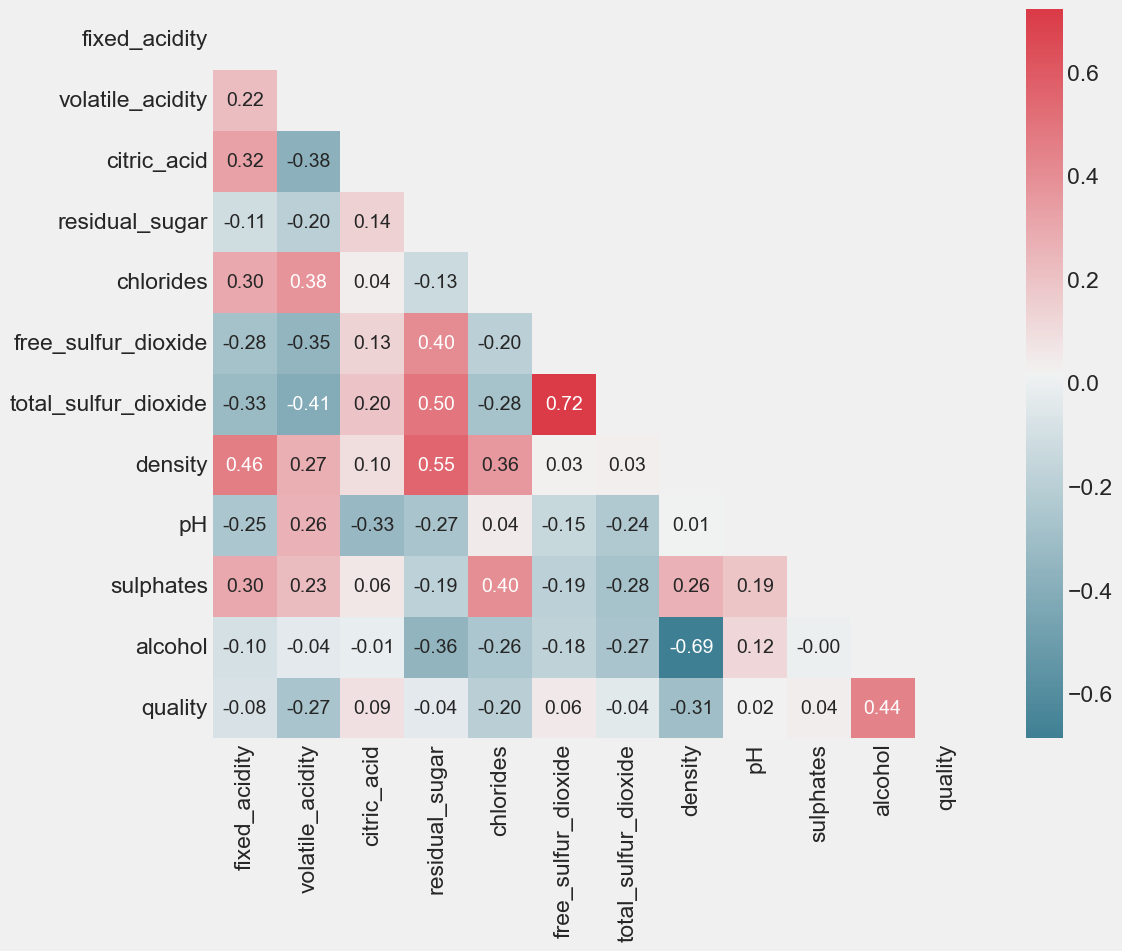

In [369]:
plt.figure(figsize = (11,9))
dropSelf = np.zeros_like(corr_matrix)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.heatmap(corr_matrix, cmap = sns.diverging_palette(220, 10, as_cmap = True), annot = True, fmt = ".2f", mask = dropSelf)

sns.set(font_scale = 1.5)

#### Distribution of each variable

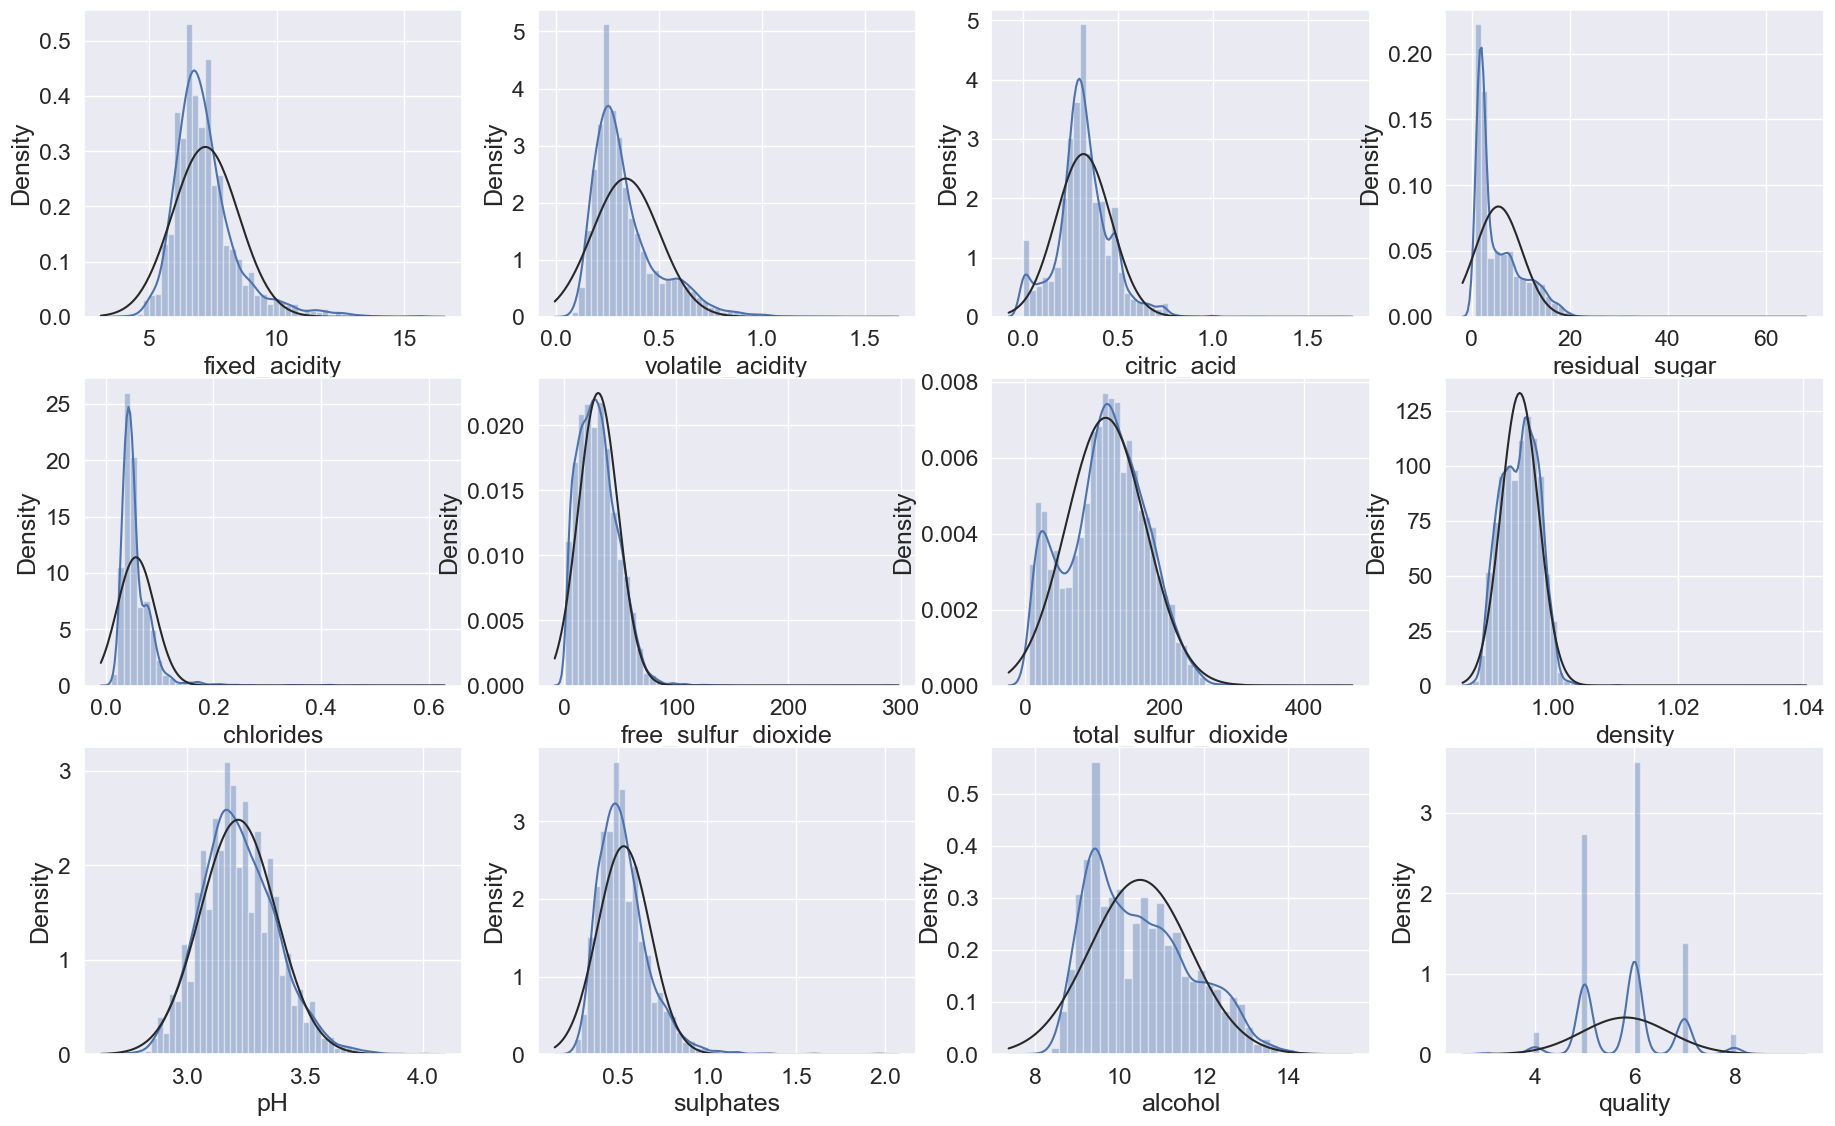

In [370]:
plt.figure(figsize = (20,22))

for i in range(1,13):
    plt.subplot(5,4,i)
    sns.distplot(df_mean[df_mean.columns[i]], fit = norm)

#### Creating 2 Bins Model of Two Types of Wine Quality Classes: 'low' = 0, 'high' = 1

In [371]:
df_bins= df_mean.copy()

bins = [0,5,10]

labels = [0, 1]
df_bins['quality_range'] = pd.cut(x=df_bins['quality'], bins = bins, labels = labels)

print(df_bins[['quality_range','quality']].tail(10))

df_bins = df_bins.drop('quality', axis = 1) 

     quality_range  quality
6487             0        5
6488             1        6
6489             1        6
6490             1        6
6491             1        6
6492             0        5
6493             1        6
6494             1        6
6495             0        5
6496             1        6


#### Quality in different wine types; 'low' = 0, 'high' = 1

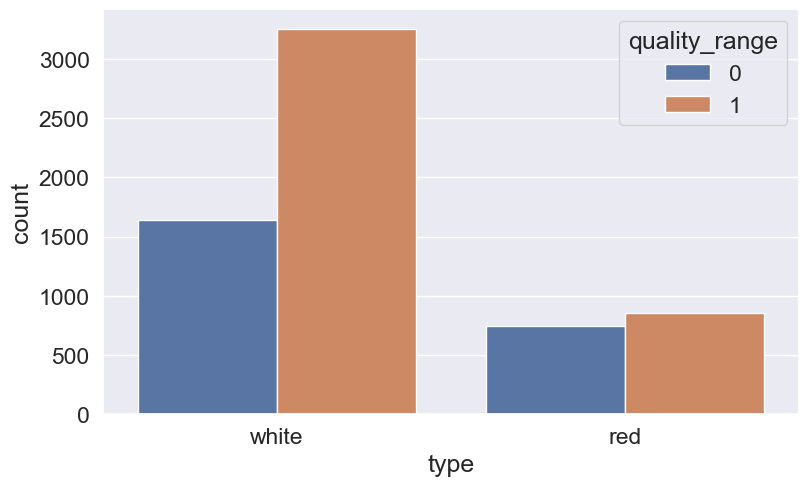

In [372]:
plt.figure(figsize = (8,5))

sns.countplot(x = 'type', hue = 'quality_range', data = df_bins)
plt.show()

#### Quality & Alcohol Relation
High quality wines are mostly red wines and have more alcohol level.

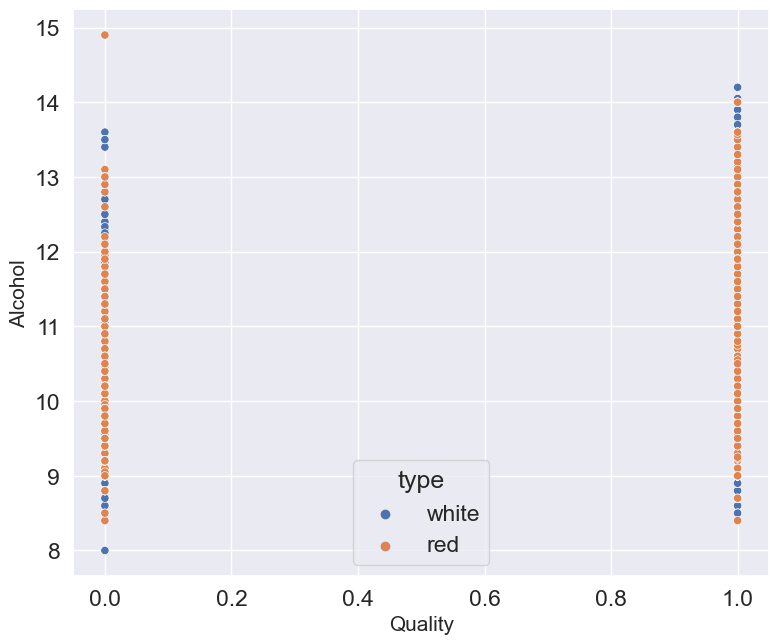

In [373]:
plt.figure(figsize=(8,7))
sns.scatterplot(x = 'quality_range', 
                y='alcohol', 
                hue='type',
                data = df_bins)
plt.xlabel('Quality',size = 15)
plt.ylabel('Alcohol', size = 15)
plt.show()

#### Quality & Volatile Acidity by Types

Fixed acidity level is low in both wine classes, especially in white wine while red wine has more in low quality class up to 1.70.  Fixed alcohol level is again high in red wine class comparing white wine in low quality. High quality class has the highest fixed alcohol level in booth wine classes. 

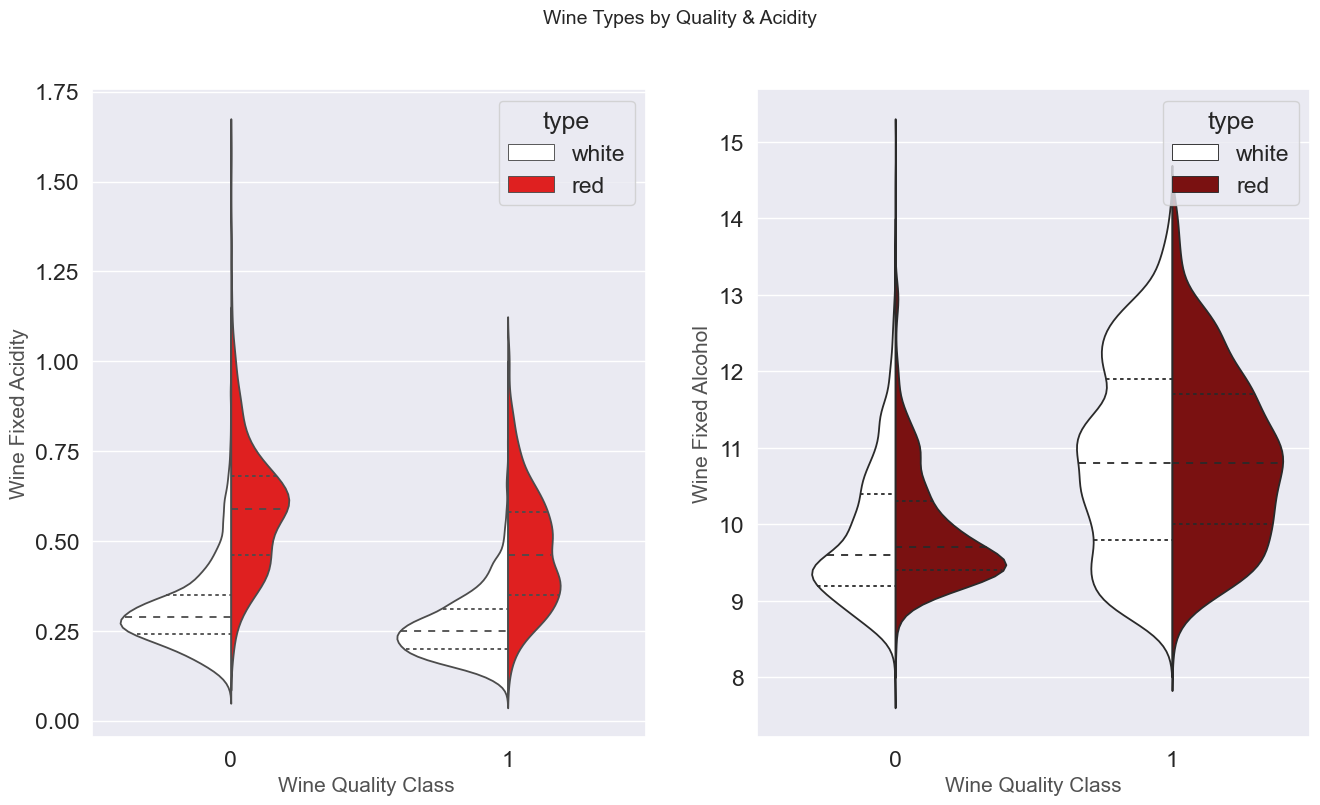

In [374]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
f.suptitle('Wine Types by Quality & Acidity', fontsize=14)

sns.violinplot(x='quality_range', y = 'volatile_acidity', hue='type', data=df_bins, split=True, inner='quart', linewidth=1.3,
               palette={'red': 'red', 'white': 'white'}, ax=ax1)
ax1.set_xlabel("Wine Quality Class ",size = 15,alpha=0.8)
ax1.set_ylabel("Wine Fixed Acidity",size = 15,alpha=0.8)

sns.violinplot(x='quality_range', y='alcohol', hue='type', data=df_bins, split=True, inner='quart', linewidth=1.3,
               palette={'red': 'darkred', 'white': 'white'}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 15,alpha=0.8)
ax2.set_ylabel("Wine Fixed Alcohol",size = 15,alpha=0.8)
plt.show()

#### Chlorides Level in Quality Classes
Chloride Level is a bit higher in red wine in contrats with white wine.

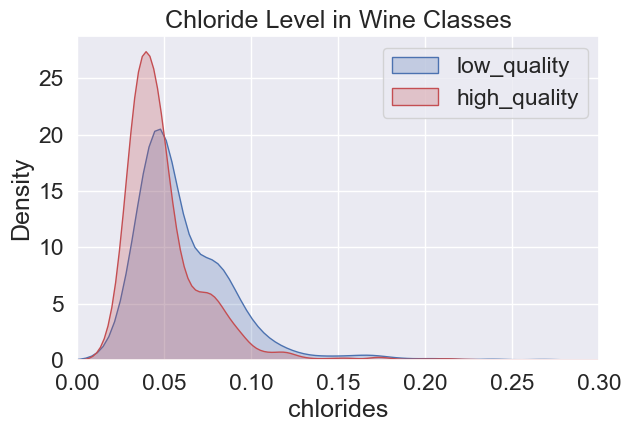

In [375]:
plt.figure(figsize= (6,4))

low_quality = df_bins [df_bins['quality_range']== 0]['chlorides']
high_quality   = df_bins [df_bins['quality_range']== 1][ 'chlorides']
ax = sns.kdeplot(data= low_quality, label= 'low_quality', shade=True, color=None)
ax = sns.kdeplot(data= high_quality,label= 'high_quality',shade=True, color= "r")

plt.title("Chloride Level in Wine Classes")
plt.xlim(0.0,0.3)
plt.legend()
plt.show()

#### Fixed Acidity & Volatile Acidity & Citric Acid Density in Quality Classes

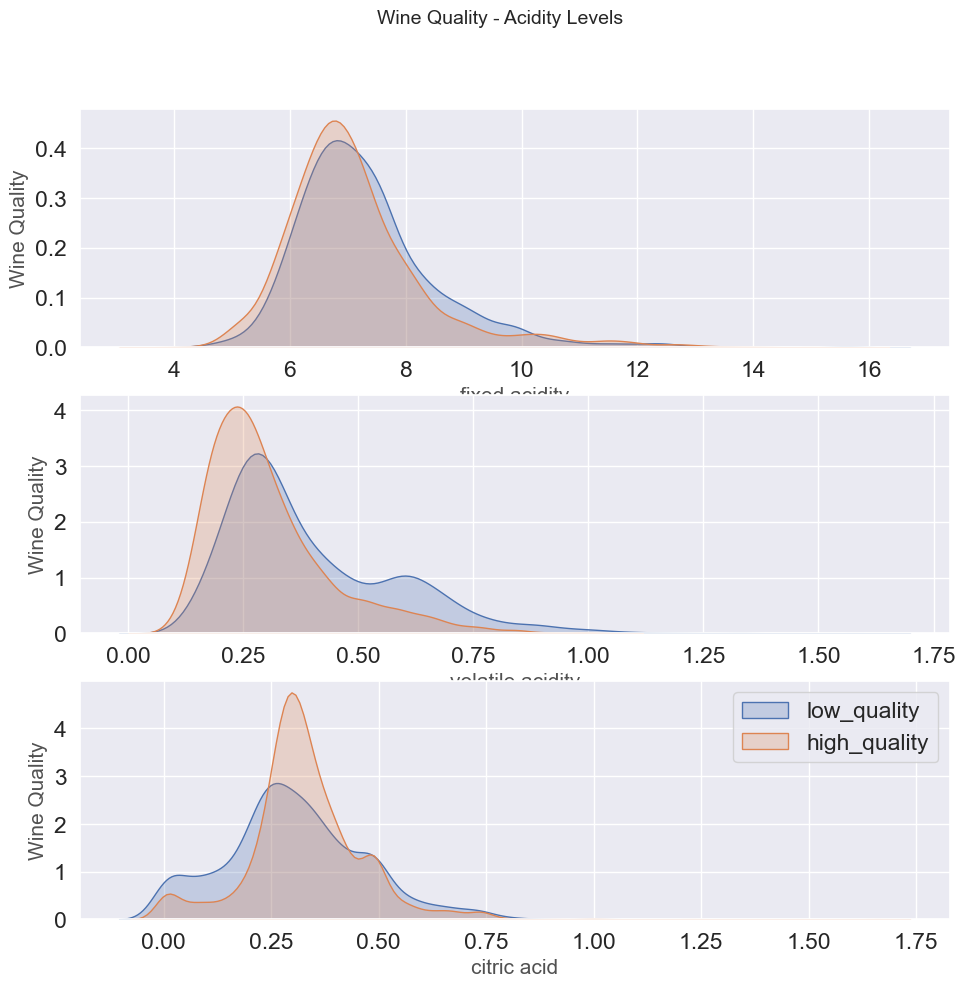

In [376]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,10))

f.suptitle('Wine Quality - Acidity Levels', fontsize=14)


fixed_acidity_low_quality    = df_bins [df_bins['quality_range']== 0]['fixed_acidity']
fixed_acidity_high_quality   = df_bins [df_bins['quality_range']== 1]['fixed_acidity']


volatile_acidity_low_quality = df_bins [df_bins['quality_range']== 0]['volatile_acidity']
volatile_acidity_high_quality= df_bins [df_bins['quality_range']== 1]['volatile_acidity']

citric_acid_low_quality      = df_bins [df_bins['quality_range']== 0]['citric_acid']
citric_acid_high_quality     = df_bins [df_bins['quality_range']== 1]['citric_acid']


sns.kdeplot(data=fixed_acidity_low_quality, label="low_quality", shade=True,ax=ax1)
sns.kdeplot(data=fixed_acidity_high_quality, label="high_quality", shade=True, ax=ax1)
ax1.set_xlabel("fixed acidity",size = 15,alpha=0.8)
ax1.set_ylabel("Wine Quality",size = 15,alpha=0.8)


sns.kdeplot(data=volatile_acidity_low_quality, label="low_quality", shade=True,ax=ax2)
sns.kdeplot(data=volatile_acidity_high_quality, label="high_quality", shade=True, ax=ax2)
ax2.set_xlabel("volatile acidity",size = 15,alpha=0.8)
ax2.set_ylabel("Wine Quality",size = 15,alpha=0.8)


sns.kdeplot(data=citric_acid_low_quality, label="low_quality", shade=True,ax=ax3)
sns.kdeplot(data=citric_acid_high_quality, label="high_quality", shade=True, ax=ax3)
ax3.set_xlabel("citric acid",size = 15,alpha=0.8)
ax3.set_ylabel("Wine Quality",size = 15,alpha=0.8)


plt.legend()
plt.show()

#### Residual Sugar Levels by Wine Quality Classes

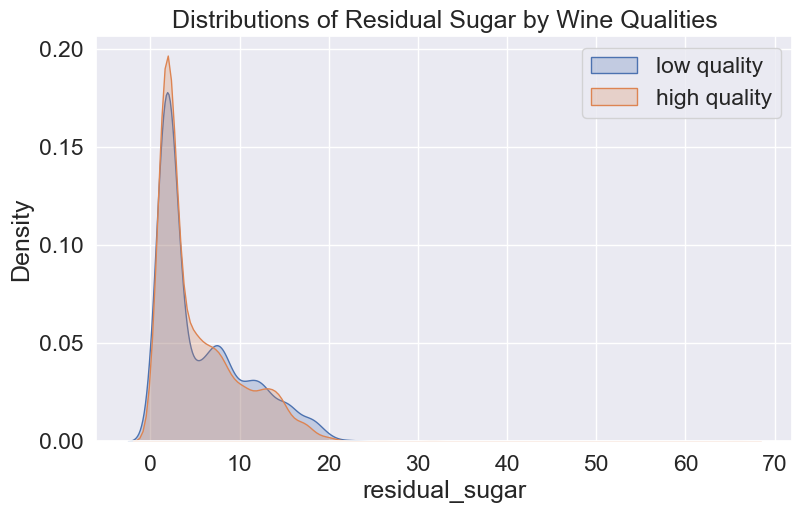

In [377]:
plt.figure(figsize=(8,5))

residual_sugar_low   = df_bins [df_bins['quality_range']== 0]['residual_sugar']
residual_sugar_high  = df_bins [df_bins['quality_range']== 1]['residual_sugar'] 
ax = sns.kdeplot(data= residual_sugar_low, label= 'low quality', shade=True)
ax = sns.kdeplot(data= residual_sugar_high,   label= 'high quality',   shade=True)

plt.title("Distributions of Residual Sugar by Wine Qualities")
plt.legend()
plt.show()

#### Sulfur Dioxide Distribution in Wine Quality Classes

There are some extreme values in low quality wine class. Total sulfur dioxide level is getting higher in some low quality wine class while general disturubution is standing up to 100 level of free sulfur dioxide.

Text(0, 0.5, 'free_sulfur_dioxide')

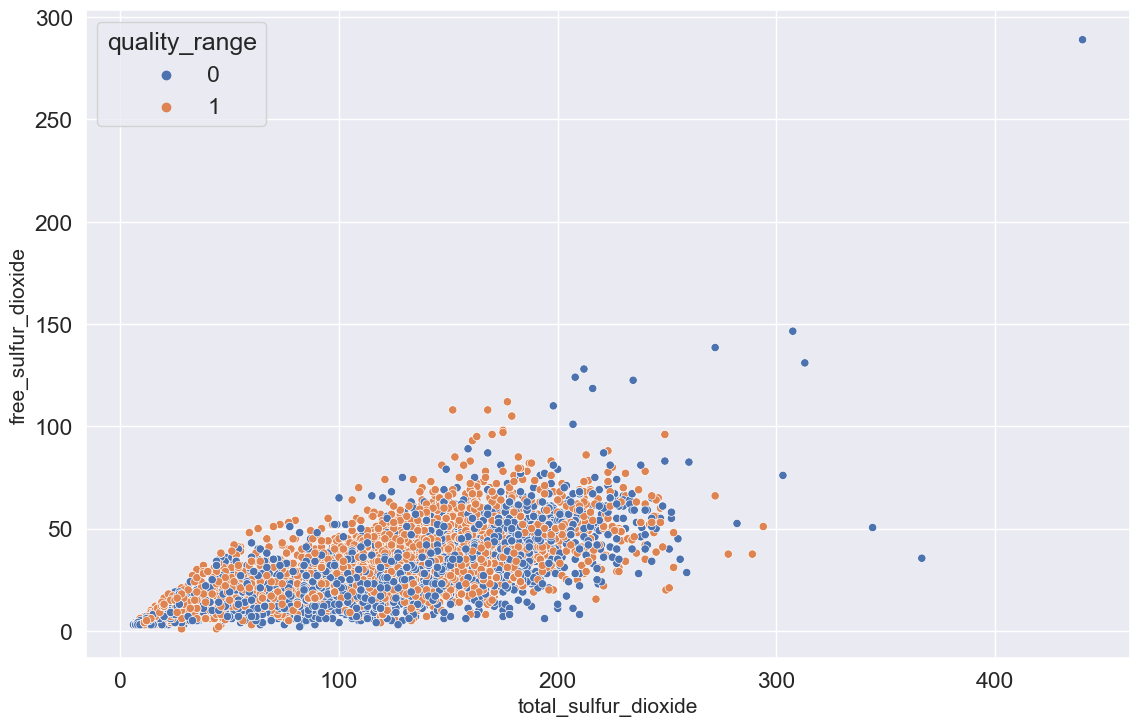

In [378]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='total_sulfur_dioxide', y='free_sulfur_dioxide', hue='quality_range',data=df_bins)
plt.xlabel('total_sulfur_dioxide',size=15)
plt.ylabel('free_sulfur_dioxide', size =15)

#### pH Level in Wine Quality

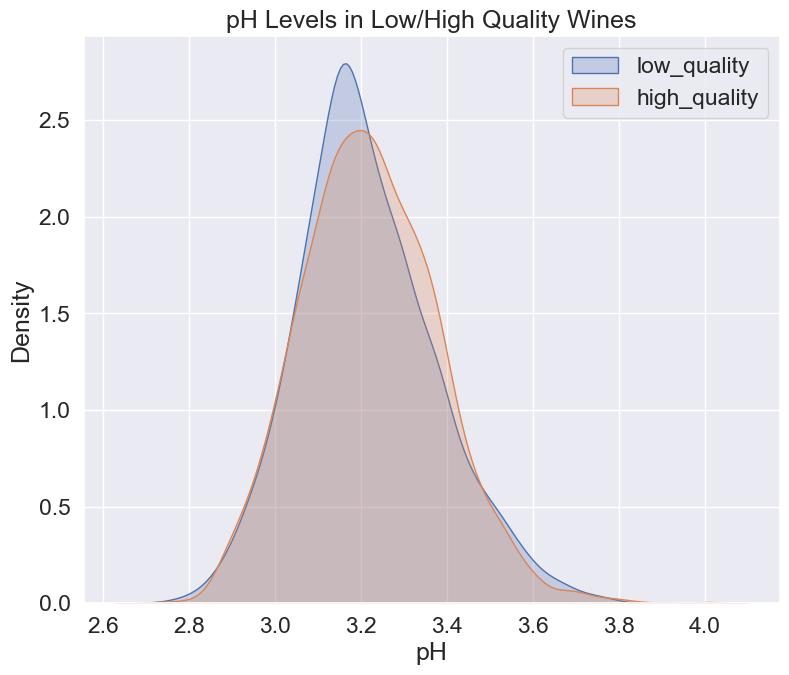

In [379]:
plt.figure(figsize=(8,7))

pH_low_quality  = df_bins [df_bins['quality_range']== 0]['pH']
pH_high_quality = df_bins [df_bins['quality_range']== 1][ 'pH']
ax = sns.kdeplot(data= pH_low_quality, label= 'low_quality', shade=True) 
ax = sns.kdeplot(data= pH_high_quality,label= 'high_quality',   shade=True)

plt.title("pH Levels in Low/High Quality Wines")
plt.xlabel('pH')
plt.legend()
plt.show()

#### Density by Wine Quality Classes

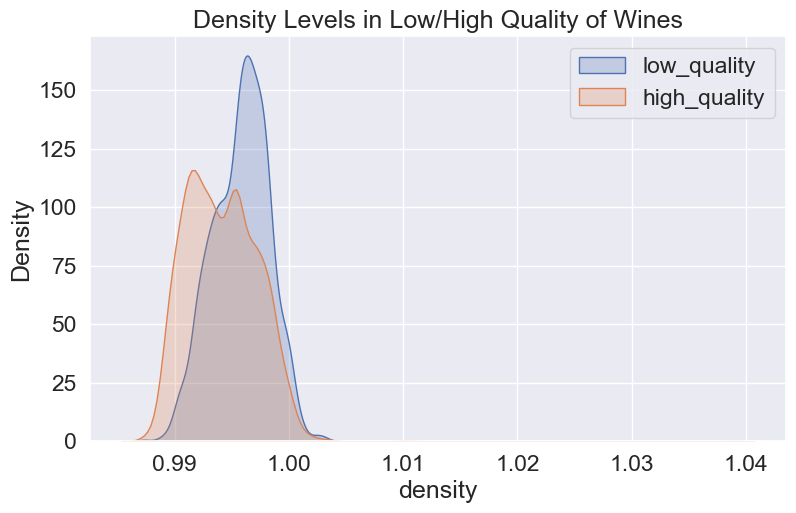

In [380]:
plt.figure(figsize=(8,5))

density_low_quality  = df_bins [df_bins['quality_range']== 0]['density']
density_high_quality = df_bins [df_bins['quality_range']== 1][ 'density']
ax = sns.kdeplot(data= density_low_quality, label= 'low_quality', shade=True) 
ax = sns.kdeplot(data= density_high_quality,label= 'high_quality', shade=True)

plt.title("Density Levels in Low/High Quality of Wines")
plt.xlabel('density')
plt.legend()
plt.show()

#### Sulphate Values in Wine Quality Classes

There is more low quality wine in between 0.4 and 0.6 levels of sulphate levels. Both quality classes have similar values.

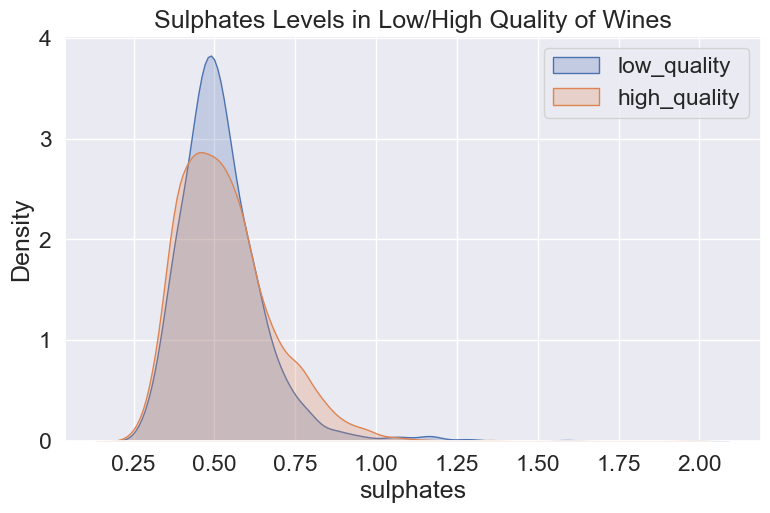

In [381]:
plt.figure(figsize=(8,5))

sulphates_low_quality = df_mean [df_bins['quality_range']== 0]['sulphates']
sulphates_high_quality = df_mean [df_bins['quality_range']== 1][ 'sulphates']
ax = sns.kdeplot(data= sulphates_low_quality, label= 'low_quality',  shade=True) 
ax = sns.kdeplot(data= sulphates_high_quality,label= 'high_quality', shade=True)

plt.title("Sulphates Levels in Low/High Quality of Wines")
plt.xlabel('sulphates')
plt.legend()
plt.show()

#### Outliers

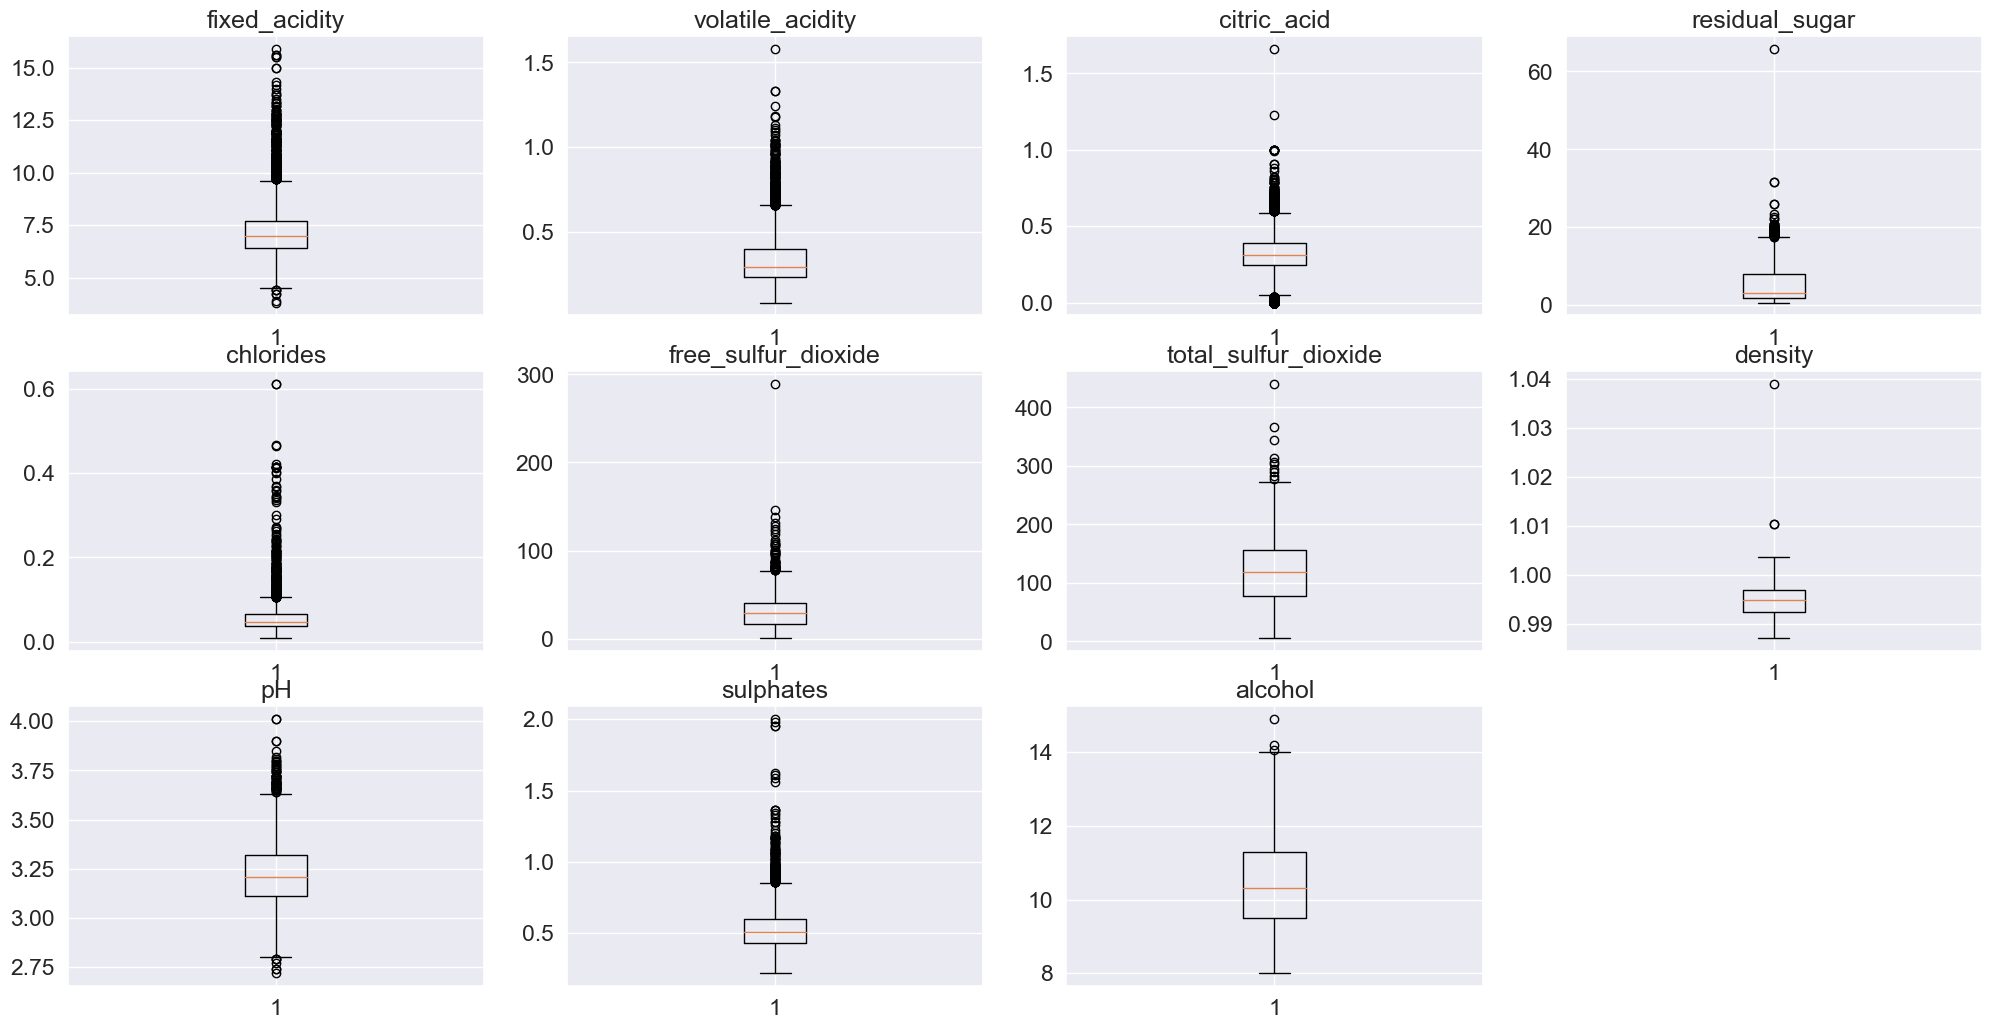

In [382]:
outliers_by_12_variables = ['fixed_acidity', 'volatile_acidity', 'citric_acid',
                            'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
                            'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'] 
plt.figure(figsize=(22,20))

for i in range(0,11):
    plt.subplot(5, 4, i+1)
    plt.boxplot(df_bins[outliers_by_12_variables[i]])
    plt.title(outliers_by_12_variables[i])

##### Winsorization

In [383]:
def winsor(x, multiplier = 3): 
    upper= x.median() + x.std()*multiplier
    for limit in np.arange(0.001, 0.20, 0.001):
        if np.max(winsorize(x,(0,limit))) < upper:
            return limit
    return None 

In [384]:
column_names = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
                                  'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']

for i in range(1,len(column_names)):

    df_bins[column_names[i]] = winsorize(df_bins[column_names[i]], (0, winsor(df_bins[column_names[i]])))

## Implementing the Logistic Regression model (2 bins); 'low' = 0, 'high' = 1

### Train-Test Split

#### Mapping the wine types

In [385]:
df_bins.type = df_bins.type.map({'white':0, 'red':1})

In [386]:
X = df_bins[['type', 'alcohol', 'density', 'volatile_acidity', 'chlorides',
       'citric_acid', 'fixed_acidity', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'sulphates', 'residual_sugar', 'pH']] 
y = df_bins.quality_range

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)

### Using the model

In [387]:
lr = LogisticRegression(random_state = 40)
lr.fit(X_train, y_train)

LogisticRegression(random_state=40)

In [388]:
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy in Train Group: {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  Group: {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy in Train Group: 0.74
Accuracy in Test  Group: 0.73


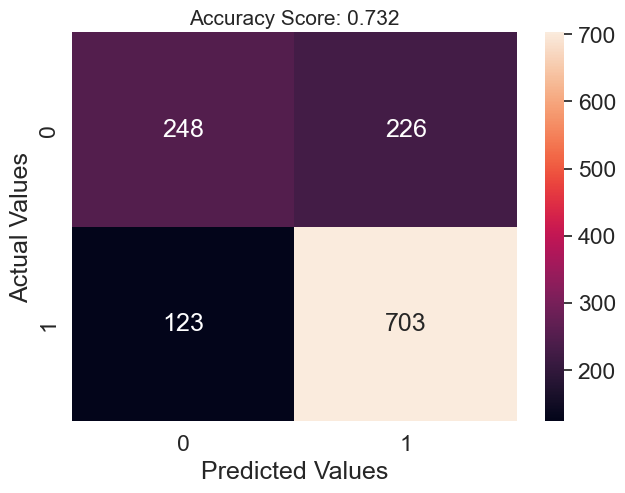

In [389]:
predictions = lr.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = confusion_matrix(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

In [390]:
pred_test  = lr.predict(X_test)
pred_train = lr.predict(X_train)

In [391]:
cm = confusion_matrix(y_test,pred_test)
cm

array([[248, 226],
       [123, 703]], dtype=int64)

### Performance Measure

In [392]:
quality_pred = LogisticRegression(random_state=40)
quality_pred.fit(X_train,y_train)

LogisticRegression(random_state=40)

In [393]:
confusion_matrix_train = confusion_matrix(y_train, pred_train)
confusion_matrix_test = confusion_matrix(y_test, pred_test)

print('Confusion Matrix Train Data', '--'*20, confusion_matrix_train, sep = '\n')
print('Confusion Matrix Test Data', '--'*20, confusion_matrix_test, sep = '\n')

Confusion Matrix Train Data
----------------------------------------
[[1023  887]
 [ 487 2800]]
Confusion Matrix Test Data
----------------------------------------
[[248 226]
 [123 703]]


In [394]:
TN = confusion_matrix_test[0][0]
TP = confusion_matrix_test[1][1]
FP = confusion_matrix_test[0][1]
FN = confusion_matrix_test[1][0]

print("(Total) True Negative:", TN)
print("(Total) True Positive:", TP)
print("(Total) Negative Positive:", FP)
print("(Total) Negative Negative:", FN)

(Total) True Negative: 248
(Total) True Positive: 703
(Total) Negative Positive: 226
(Total) Negative Negative: 123


In [395]:
FP + FN

349

#### Accuracy

In [396]:
print("Accuracy Score:",quality_pred.score(X_test, y_test))

Accuracy Score: 0.7315384615384616


#### Error Rate

In [397]:
error_rate = 1 - (accuracy_score(y_test, pred_test))  
print(f"Error Rate: {error_rate}")

Error Rate: 0.2684615384615384


#### Precision: Out of all the predicted positive instances, how many were predicted correctly = $\frac{(TP)}{(TP + FP)}$ 

In [398]:
print("Precision Score:",  precision_score(y_test, pred_test, average = 'micro'))

Precision Score: 0.7315384615384616


#### Recall: (Out of all the positive classes, how many instances were identified correctly = $\frac{(TP)}{(TP + FN)}$ 

In [399]:
print("Recall Score:",  recall_score(y_test, pred_test, average = 'micro'))

Recall Score: 0.7315384615384616


#### Specificity = $\frac{(TN)}{(TN + FP)}$

In [400]:
print(" Specificity Score:",  (TN)/(TN + FP)) 

 Specificity Score: 0.5232067510548524


#### F1-Score: From Precision and Recall, F-Measure is computed and used as metrics sometimes. F – Measure is nothing but the harmonic mean of Precision and Recall = $\frac {(2 • Recall • Precision)} {(Recall + Precision)}$

In [401]:
precision_s = precision_score(y_test, pred_test,average = 'micro')
recall_s    = recall_score(y_test, pred_test, average = 'micro')


print("F1_score:",  2 * ((precision_s*recall_s)/(precision_s + recall_s)))

F1_score: 0.7315384615384616


In [402]:
print(classification_report(y_test,pred_test))

print("f1_score: {:.2f}".format(2 * ((precision_s*recall_s)/(precision_s + recall_s))))
print("recall_score: {:.2f}".format(recall_score(y_test, pred_test, average = 'micro')))
print("precision_score: {:.2f}".format(precision_score(y_test, pred_test, average = 'micro')))

print('\n')
metrics =  precision_recall_fscore_support(y_test, pred_test)
print("Precision:" , metrics[0]) 
print("Recall:" , metrics[1]) 
print("F1 Score:" , metrics[2]) 

              precision    recall  f1-score   support

           0       0.67      0.52      0.59       474
           1       0.76      0.85      0.80       826

    accuracy                           0.73      1300
   macro avg       0.71      0.69      0.69      1300
weighted avg       0.72      0.73      0.72      1300

f1_score: 0.73
recall_score: 0.73
precision_score: 0.73


Precision: [0.66846361 0.75672766]
Recall: [0.52320675 0.85108959]
F1 Score: [0.58698225 0.8011396 ]


#### ROC/AUC

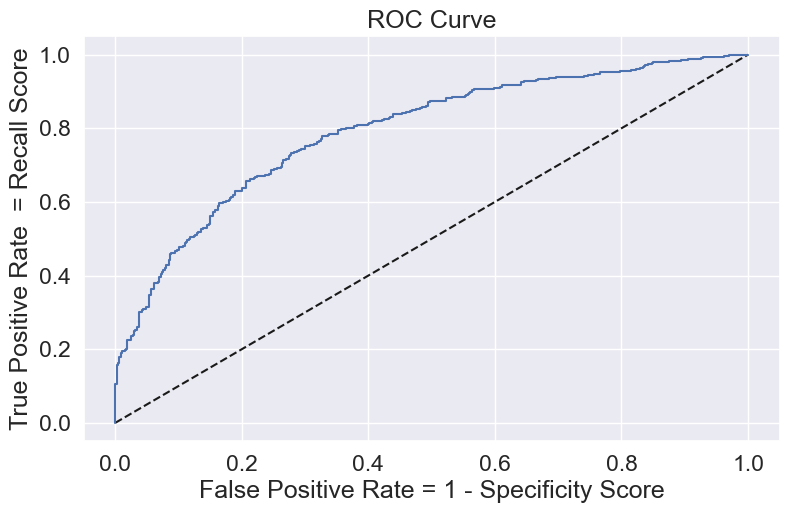

In [403]:
probs = quality_pred.predict_proba(X_test)[:,1]

fpr, tpr, thresholds  = roc_curve(y_test, probs)

plt.figure(figsize = (8,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()

In [404]:
print('AUC:', roc_auc_score(y_test.values, probs))

AUC: 0.7919105853025612


#### PRECISION RECALL CURVE 
(The precision is the ratio $\frac{(TP)}{(TP + FP)}$ where TP is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio $\frac{(TP)}{(TP + FN)}$ where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.)

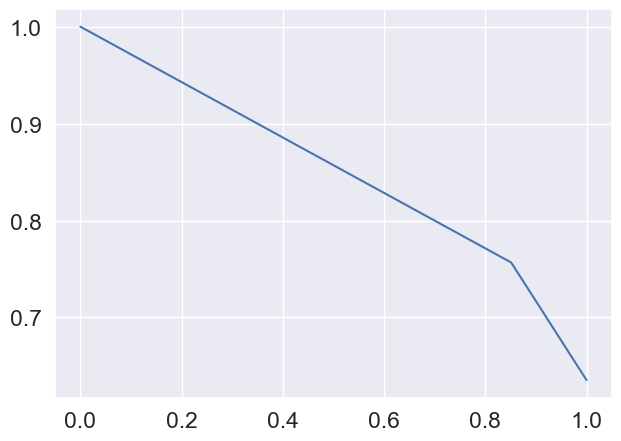

In [405]:
precision, recall, _ = precision_recall_curve(y_test, pred_test)

plt.plot(recall, precision)
plt.show()

#### Log Loss (calculating the difference between ground truth and predicted score for every observation and average those errors over all observations.)

In [406]:
print("Log-Loss:" , log_loss(y_test.values, probs))
print("Error Rate:" , 1- accuracy_score(y_test.values, pred_test))

Log-Loss: 0.5265635478029033
Error Rate: 0.2684615384615384


#### C value

In [407]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
accuracy_df = pd.DataFrame(columns = ['C_values','Accuracy'])

accuracy_values = pd.DataFrame(columns=['C Value', 'Accuracy Train', 'Accuracy Test'])

for c in C_values:
    
    # Apply logistic regression model to training data
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 0)
    lr.fit(X_train,y_train)
    accuracy_values = accuracy_values.append({'C Value': c,
                                                    'Accuracy Train' : lr.score(X_train, y_train),
                                                    'Accuracy Test': lr.score(X_test, y_test)
                                                    }, ignore_index=True)
display(accuracy_values)

,C Value,Accuracy Train,Accuracy Test
0,0.001,0.681162,0.656154
1,0.010,0.694247,0.672308
2,0.100,0.723109,0.710769
3,1.000,0.735617,0.731538
4,10.000,0.733308,0.730000
5,100.000,0.731383,0.726154
6,1000.000,0.736579,0.734615


## Implementing the Logistic Regression model (3 bins); 'low' = 0,'average' = 1, 'high' = 2

### Train-Test Split

In [408]:
df_bins3 = df_mean.copy()

In [409]:
df_bins3.type = df_bins3.type.map({'white':0, 'red':1})

In [410]:
bins = [0,4,7,10]

labels = [0,1,2]

df_bins3['quality_range']= pd.cut(x=df_bins3['quality'], bins=bins, labels = labels)

print(df_bins3[['quality_range','quality']].head(10))

  quality_range  quality
0             1        6
1             1        6
2             1        6
3             1        6
4             1        6
5             1        6
6             1        6
7             1        6
8             1        6
9             1        6


In [411]:
X = df_bins3[['type', 'alcohol', 'density', 'volatile_acidity', 'chlorides',
       'citric_acid', 'fixed_acidity', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'sulphates', 'residual_sugar', 'pH']]
y = df_bins3.quality_range

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

### Using the model

In [412]:
lr = LogisticRegression(random_state = 40)
lr.fit(X_train, y_train)

LogisticRegression(random_state=40)

In [413]:
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy Score of Train Model: {:.2f}'.format(train_accuracy), 
      'Accuracy Score of Test  Model: {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy Score of Train Model: 0.93
Accuracy Score of Test  Model: 0.93


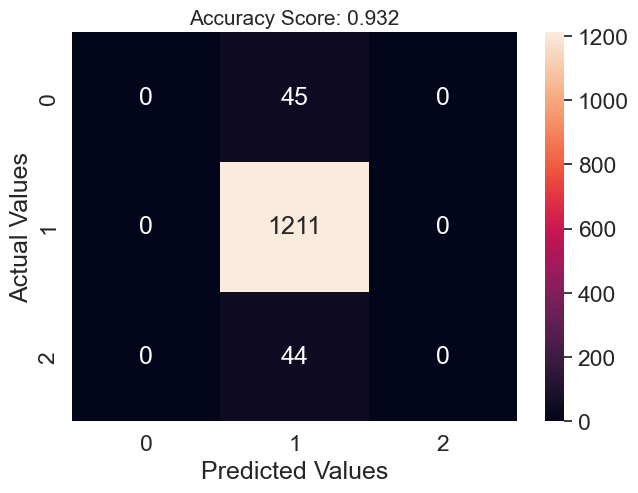

In [414]:
predictions = lr.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = confusion_matrix(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

In [415]:
y_pred = lr.predict(X_test)
y_pred[y_pred == 2]

array([], dtype=int64)

In [416]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[   0,   45,    0],
       [   0, 1211,    0],
       [   0,   44,    0]], dtype=int64)

### Performance Measure

In [417]:
quality_pred = LogisticRegression(random_state = 40)
quality_pred.fit(X_train,y_train)

LogisticRegression(random_state=40)

In [418]:
pred_train = lr.predict(X_train)
pred_test  = lr.predict(X_test)

In [419]:
confusion_matrix_train = confusion_matrix(y_train,pred_train)
confusion_matrix_test = confusion_matrix(y_test,pred_test)

print('Confusion Matrix Train Data', '--'*20, confusion_matrix_train, sep='\n')
print('Confusion Matrix Test  Data ', '--'*20, confusion_matrix_test, sep='\n')

Confusion Matrix Train Data
----------------------------------------
[[   0  201    0]
 [   0 4842    0]
 [   0  154    0]]
Confusion Matrix Test  Data 
----------------------------------------
[[   0   45    0]
 [   0 1211    0]
 [   0   44    0]]


In [420]:
print("(Total) True Negative:", TN)
print("(Total) True Positive:", TP)
print("(Total) Negative Positive:", FP)
print("(Total) Negative Negative:", FN)

(Total) True Negative: 248
(Total) True Positive: 703
(Total) Negative Positive: 226
(Total) Negative Negative: 123


#### Accuracy

In [421]:
print("Accuracy Score of Test Model:",  quality_pred.score(X_test, y_test))

Accuracy Score of Test Model: 0.9315384615384615


#### Error Rate

In [422]:
error_rate = 1 - (accuracy_score(y_test, pred_test))
error_rate

0.06846153846153846

#### Precision

In [423]:
print("Precision Score:",  precision_score(y_test, pred_test, average='micro'))

Precision Score: 0.9315384615384615


#### Recall

In [424]:
print("Recall Score: ",  recall_score(y_test, pred_test, average='micro'))

Recall Score:  0.9315384615384615


#### F1 Score

In [425]:
precision_s = precision_score(y_test, pred_test,average = 'micro')
recall_s = recall_score(y_test, pred_test, average = 'micro')


print("F1 score:",  2 * ((precision_s * recall_s)/(precision_s + recall_s)))

F1 score: 0.9315384615384615


In [426]:
print(classification_report(y_test,pred_test))

print("f1_score(): {:.2f}".format(2 * ((precision_s * recall_s) / (precision_s + recall_s))))
print("recall_score(): {:.2f}".format(recall_score(y_test, pred_test, average = 'micro')))
print("precision_score(): {:.2f}".format(precision_score(y_test, pred_test, average = 'micro')))

print('\n')
metrikler =  precision_recall_fscore_support(y_test, pred_test)
print("Precision:" , metrics[0]) 
print("Recall:" , metrics[1]) 
print("F1 Score:" , metrics[2])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.93      1.00      0.96      1211
           2       0.00      0.00      0.00        44

    accuracy                           0.93      1300
   macro avg       0.31      0.33      0.32      1300
weighted avg       0.87      0.93      0.90      1300

f1_score(): 0.93
recall_score(): 0.93
precision_score(): 0.93


Precision: [0.66846361 0.75672766]
Recall: [0.52320675 0.85108959]
F1 Score: [0.58698225 0.8011396 ]


#### ROC/AUC

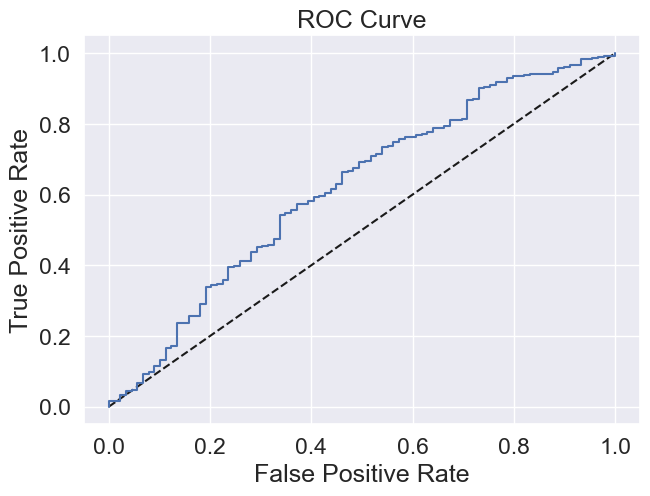

In [427]:
probs = quality_pred.predict_proba(X_test)[:,1]

fpr, tpr, thresholds  = roc_curve(y_test, probs, pos_label=1)


# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [428]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

print('AUC:', multiclass_roc_auc_score(y_test.values, y_pred))

AUC: 0.5


#### Precision Recall Curve

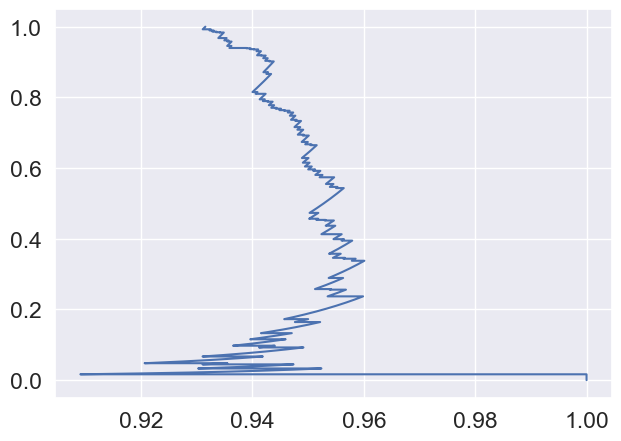

In [429]:
precision, recall, _ = precision_recall_curve(y_test, probs, pos_label=1)

plt.plot(precision, recall)
plt.show()

#### C Value

In [430]:
C_values = [0.001,0.01,0.1,1,10,100, 1000]
accuracy_df = pd.DataFrame(columns = ['C_values','Accuracy'])

accuracy_values = pd.DataFrame(columns=['C Value', 'Accuracy Train', 'Accuracy Test'])

for c in C_values: 
    
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 0)
    lr.fit(X_train,y_train)
    accuracy_values = accuracy_values.append({'C Value': c,
                                                    'Accuracy Train' : lr.score(X_train, y_train),
                                                    'Accuracy Test': lr.score(X_test, y_test)
                                                    }, ignore_index=True)
display(accuracy_values)

,C Value,Accuracy Train,Accuracy Test
0,0.001,0.931691,0.931538
1,0.010,0.931691,0.931538
2,0.100,0.931691,0.931538
3,1.000,0.931691,0.931538
4,10.000,0.931691,0.931538
5,100.000,0.931691,0.931538
6,1000.000,0.931691,0.931538


## Dealing with Imbalanced Data

### In this case, the best way to see the impact of dealing with imbalanced data is to check resampling imblance data. In previous steps, bins were added in low and high ranges on quality variable, this section will show the results by using resampling method.

#### Only dealing with 2 bins 

In [431]:
df_mean_imb = df_mean.copy()

In [432]:
bins = [0,4,10] 


labels = [0, 1]
df_mean_imb['quality_range']= pd.cut(x = df_mean_imb['quality'], bins = bins, labels = labels) 

print(df_mean_imb[['quality_range','quality']].tail(10)) 

df_mean_imb = df_mean_imb.drop('quality', axis = 1)

     quality_range  quality
6487             1        5
6488             1        6
6489             1        6
6490             1        6
6491             1        6
6492             1        5
6493             1        6
6494             1        6
6495             1        5
6496             1        6


Low Quality 0: 96.21%
High Quality 1: 3.79%


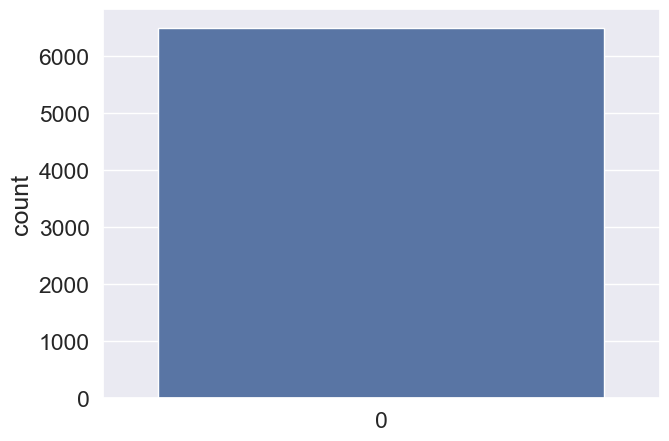

In [433]:
import builtins

sns.countplot(df_mean_imb.quality_range)
    
print("Low Quality 0: {:.2f}%".format(builtins.sum(df_mean_imb.quality_range) / len(df_mean_imb.quality_range) * 100))
print("High Quality 1: {:.2f}%".format((len(df_mean_imb.quality_range) - builtins.sum(df_mean_imb.quality_range)) / len(df_mean_imb.quality_range) * 100))

In [434]:
balance = (df_mean_imb.quality_range.value_counts()[1]/df_mean_imb.quality_range.shape[0])*100
print('Data Quality Percentage:\n', balance,'%')

Data Quality Percentage:
 96.21363706325997 %


### Resampling Imbalance Data

In [435]:
smote = SMOTE() 

In [436]:
df_mean_imb.type = df_mean_imb.type.map({'white':0, 'red':1})

(6497, 12) (6497,)
(12502, 12) (12502,)


<AxesSubplot: ylabel='count'>

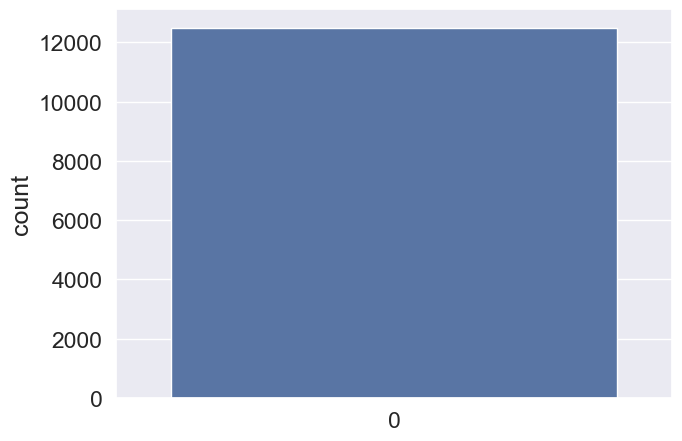

In [437]:
X =  df_mean_imb.drop(['quality_range'], axis=1) 
y =  df_mean_imb.quality_range 

X_sm, y_sm = smote.fit_resample(X,y) 

print(X.shape, y.shape) 
print(X_sm.shape, y_sm.shape) 
sns.countplot(y_sm) 

In [438]:
def create_model(X, y): 
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=40, stratify = y) 
    logreg_model = LogisticRegression() 
    logreg_model.fit(X_train, y_train) 

    pred_train = logreg_model.predict(X_train) 
    pred_test = logreg_model.predict(X_test) 
    confusion_matrix_train = confusion_matrix(y_train, pred_train) 
    confusion_matrix_test = confusion_matrix(y_test, pred_test) 
    print("Accuracy of Test Model : ",  logreg_model.score(X_test, y_test)) 
    print("Train Data Set") 
    print(classification_report(y_train,pred_train) ) 
    print("Test Data Set ") 
    print(classification_report(y_test,pred_test) ) 
    return  None 

In [439]:
create_model(X_sm,y_sm)

Accuracy of Test Model :  0.7588964414234306
Train Data Set
              precision    recall  f1-score   support

           0       0.77      0.71      0.74      5000
           1       0.73      0.78      0.76      5001

    accuracy                           0.75     10001
   macro avg       0.75      0.75      0.75     10001
weighted avg       0.75      0.75      0.75     10001

Test Data Set 
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1251
           1       0.75      0.77      0.76      1250

    accuracy                           0.76      2501
   macro avg       0.76      0.76      0.76      2501
weighted avg       0.76      0.76      0.76      2501



### Cross validation with 2 bins

In [440]:
df_bins.tail(10)

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_range
6487,1,6.6,0.725,0.20,7.8,0.073,29.0,79.0,0.99770,3.29,0.54,9.2,0
6488,1,6.3,0.550,0.15,1.8,0.077,26.0,35.0,0.99314,3.32,0.82,11.6,1
6489,1,5.4,0.740,0.09,1.7,0.089,16.0,26.0,0.99402,3.67,0.56,11.6,1
6490,1,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1
6491,1,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,1
6492,1,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,0
6493,1,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,1
6494,1,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1
6495,1,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,0
6496,1,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,1


In [441]:
X = df_bins.drop(['quality_range'], axis=1)
y = df_bins.quality_range
y = np.array(y)

In [442]:
plt.style.use('fivethirtyeight')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
print("Number of Rows in Training dataset: {}".format(len(X_train)))
print("Number of Targets in Training dataset: {}".format(len(y_train)))
print("Number of Rows in Test dataset: {}".format(len(X_test)))
print("Number of Targets in Test dataset: {}".format(len(y_test)))

Number of Rows in Training dataset: 4547
Number of Targets in Training dataset: 4547
Number of Rows in Test dataset: 1950
Number of Targets in Test dataset: 1950


(0.0, 1000.0)

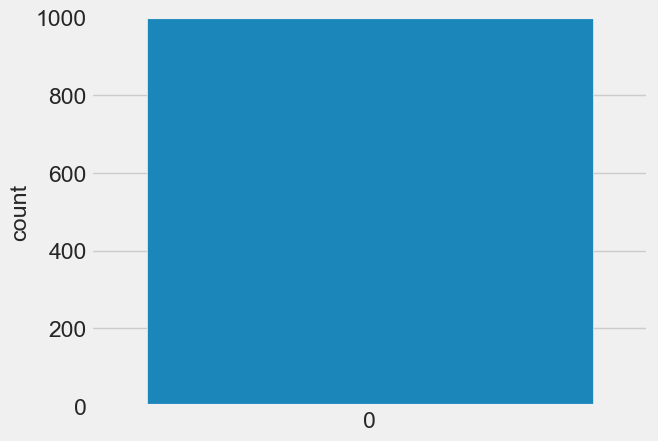

In [443]:
sns.countplot(y_test)
plt.ylim((0,1000))

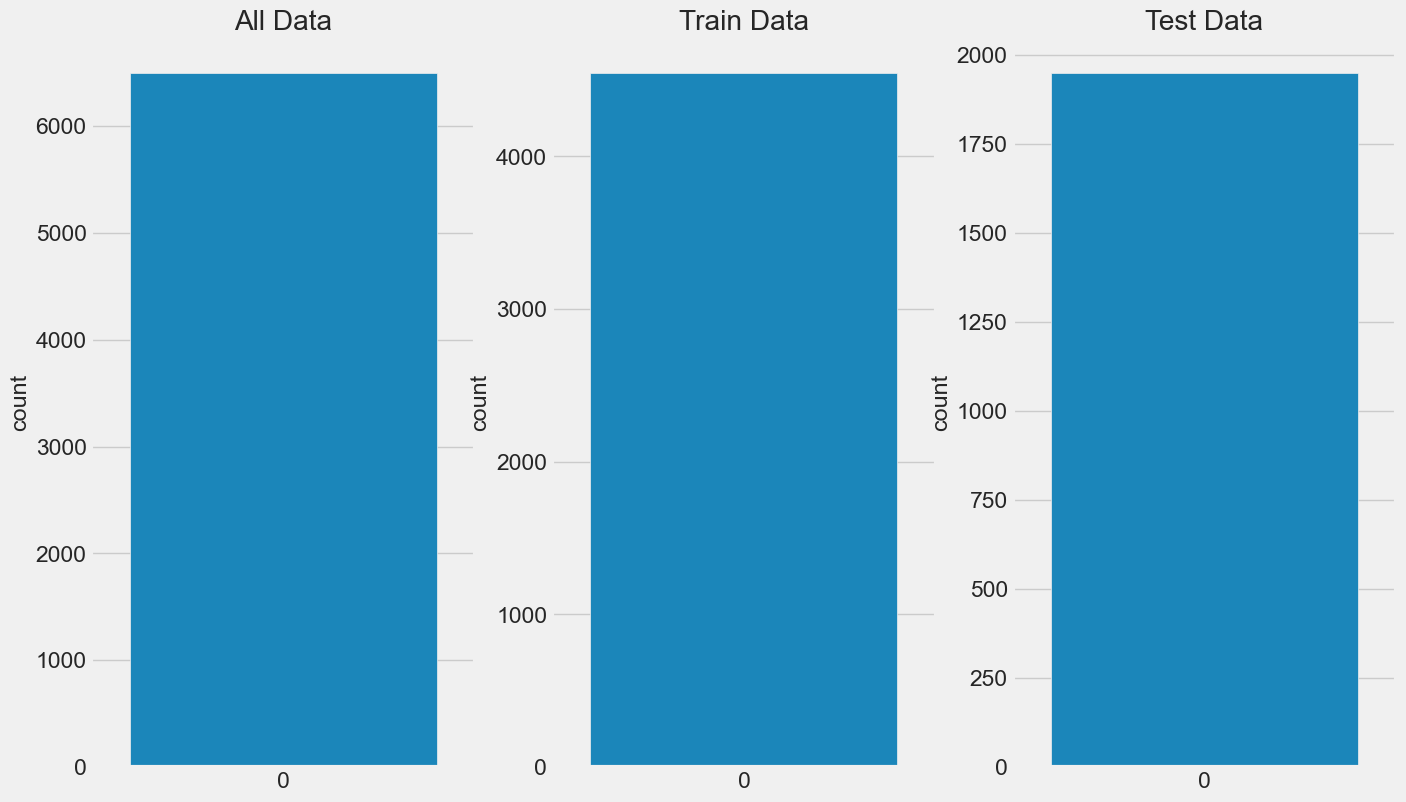

In [444]:
plt.figure(figsize = (15,9))
y_list = [y, y_train, y_test]
titles = ['All Data','Train Data', 'Test Data']

for i in range(1,4):
    plt.subplot(1,3,i)
    sns.countplot(y_list[i-1])
    plt.title(titles[i-1])

In [445]:
print("Percentage of Entire Dataset:{:.0f}%".format(len(y[y==0])/len(y)*100))
print("Percentage of Test Data:{:.0f}%".format(len(y_test[y_test==0])/len(y_test)*100))
print("Percentage of Training Data:{:.0f}%".format(len(y_train[y_train==0])/len(y_train)*100))

Percentage of Entire Dataset:37%
Percentage of Test Data:37%
Percentage of Training Data:37%


In [446]:
LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
tahmin_eğitim = model.predict(X_train)
tahmin_test = model.predict(X_test)
model.score(X_test, y_test)

0.7394871794871795

### K-fold Cross Validation
A technique for evaluating predictive models

In [447]:
kf = KFold(n_splits=5, shuffle=True, random_state=40)

In [448]:
X.loc[[3,5]]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
3,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
5,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1


In [449]:
parcalar = kf.split(X)
for num, (train_index, test_index) in enumerate(parcalar): 
    print("{}.Training Set Size : {}".format(num+1,len(train_index)))  
    print("{}.Test Set Size     : {}".format(num+1,len(test_index))) 
    print('-'*26)

1.Training Set Size : 5197
1.Test Set Size     : 1300
--------------------------
2.Training Set Size : 5197
2.Test Set Size     : 1300
--------------------------
3.Training Set Size : 5198
3.Test Set Size     : 1299
--------------------------
4.Training Set Size : 5198
4.Test Set Size     : 1299
--------------------------
5.Training Set Size : 5198
5.Test Set Size     : 1299
--------------------------


In [450]:
model2 = LogisticRegression()
pieces = kf.split(X)
accuracy_list = []

for i, (egitim_indeks, test_indeks) in enumerate(pieces):
    
    X_train, y_train = X.loc[train_index], y[train_index]
    X_test, y_test = X.loc[test_indeks], y[test_indeks]
    
    model2.fit(X_train, y_train)
    tahmin = model2.predict(X_test)
    accuracy_value = model2.score(X_test, y_test)  
    
    accuracy_list.append(accuracy_value)
    
    print("{}.Accuracy Value of Pieces: {:.3f}".format(i+1, accuracy_value))
    print("-"*30)

1.Accuracy Value of Pieces: 0.725
------------------------------
2.Accuracy Value of Pieces: 0.732
------------------------------
3.Accuracy Value of Pieces: 0.742
------------------------------
4.Accuracy Value of Pieces: 0.729
------------------------------
5.Accuracy Value of Pieces: 0.709
------------------------------


In [451]:
print("Avarage Accuracy Value: {:.2f}".format(np.mean(accuracy_list)))

Avarage Accuracy Value: 0.73


### Cross Validation Score & Cross Validate

In [452]:
lrm = LogisticRegression()
cv = cross_validate(estimator=lrm,
                     X=X,
                     y=y,
                     cv=10,return_train_score=True
                    )
print('Test Scores: ', cv['test_score'], sep = '\n')
print("-"*50)
print('Train Scores: ', cv['train_score'], sep = '\n')

Test Scores: 
[0.65076923 0.67384615 0.73846154 0.69846154 0.73230769 0.72153846
 0.71384615 0.80739599 0.65947612 0.7596302 ]
--------------------------------------------------
Train Scores: 
[0.74756285 0.7325124  0.74003763 0.74465538 0.73576193 0.72361895
 0.73319651 0.71169631 0.7375171  0.73221614]


In [453]:
print('Mean of Test Set  : ', cv['test_score'].mean())
print('Mean of Train Set : ', cv['train_score'].mean())

Mean of Test Set  :  0.7155733080478843
Mean of Train Set :  0.7338775195904128


In [454]:
cv = cross_validate(estimator=lrm, 
                     X = X,
                     y = y,
                     cv = 10, return_train_score = True,
                     scoring = ['accuracy', 'r2', 'precision']
                    )

In [455]:
print('Test Set Accuracy Mean: {:.2f}'.format(cv['test_accuracy'].mean()))
print('Test Set R Square Mean: {:.2f}'.format(cv['test_r2'].mean()))
print('Test Set Precision Mean: {:.2f}'.format(cv['test_precision'].mean()))
print('Train Set Accuracy Mean: {:.2f}'.format(cv['train_accuracy'].mean()))
print('Train Set R Square Mean: {:.2f}'.format(cv['train_r2'].mean()))
print('Train Set Precision Mean: {:.2f}'.format(cv['train_precision'].mean()))

Test Set Accuracy Mean: 0.72
Test Set R Square Mean: -0.22
Test Set Precision Mean: 0.76
Train Set Accuracy Mean: 0.73
Train Set R Square Mean: -0.15
Train Set Precision Mean: 0.77


In [456]:
cv = cross_val_score(estimator=lrm,
                     X=X,
                     y=y,
                     cv=10                    
                    )
print('Model Scores: ', cv, sep = '\n')

Model Scores: 
[0.65076923 0.67384615 0.73846154 0.69846154 0.73230769 0.72153846
 0.71384615 0.80739599 0.65947612 0.7596302 ]


In [457]:
y_pred = cross_val_predict(estimator=lrm, X=X, y=y, cv=10)
print(y_pred[0:10])

[1 0 1 1 1 1 0 1 0 1]


## Hyperparameter tuning
### Grid Search and Random Search

In [458]:
logreg = LogisticRegression()
print(logreg.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Grid Search

In [459]:
parameters = {"C": [10 ** x for x in range (-5, 5, 1)],
                "penalty": ['l1', 'l2']
                }

parameters

{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
 'penalty': ['l1', 'l2']}

In [460]:
grid_cv = GridSearchCV(estimator=logreg,
                       param_grid = parameters,
                       cv = 10
                      )
grid_cv.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'penalty': ['l1', 'l2']})

In [461]:
print("The Best Parametre: ", grid_cv.best_params_)
print("The Best Score: ", grid_cv.best_score_)

The Best Parametre:  {'C': 10000, 'penalty': 'l2'}
The Best Score:  0.7269612421476829


In [462]:
results = grid_cv.cv_results_
df = pd.DataFrame(results)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000998,0.000773,0.000000,0.000000,0.00001,l1,"{'C': 1e-05, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
1,0.032912,0.011605,0.001596,0.000662,0.00001,l2,"{'C': 1e-05, 'penalty': 'l2'}",0.636923,0.635385,0.643077,0.635385,0.635385,0.633846,0.633846,0.631741,0.633282,0.6302,0.634907,0.003295,10
2,0.000897,0.000538,0.000000,0.000000,0.0001,l1,"{'C': 0.0001, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3,0.039097,0.004209,0.001396,0.000489,0.0001,l2,"{'C': 0.0001, 'penalty': 'l2'}",0.646154,0.644615,0.664615,0.650769,0.652308,0.626154,0.638462,0.617874,0.633282,0.6302,0.640443,0.013249,9
4,0.000898,0.000299,0.000000,0.000000,0.001,l1,"{'C': 0.001, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [463]:
df = df[['param_penalty','param_C', 'mean_test_score']]
df = df.sort_values(by = 'mean_test_score', ascending = False)
df

,param_penalty,param_C,mean_test_score
19,l2,10000,0.726961
13,l2,10,0.724960
17,l2,1000,0.723269
15,l2,100,0.720040
11,l2,1,0.715573
9,l2,0.1,0.712188
7,l2,0.01,0.686018
5,l2,0.001,0.667533
3,l2,0.0001,0.640443
1,l2,0.00001,0.634907


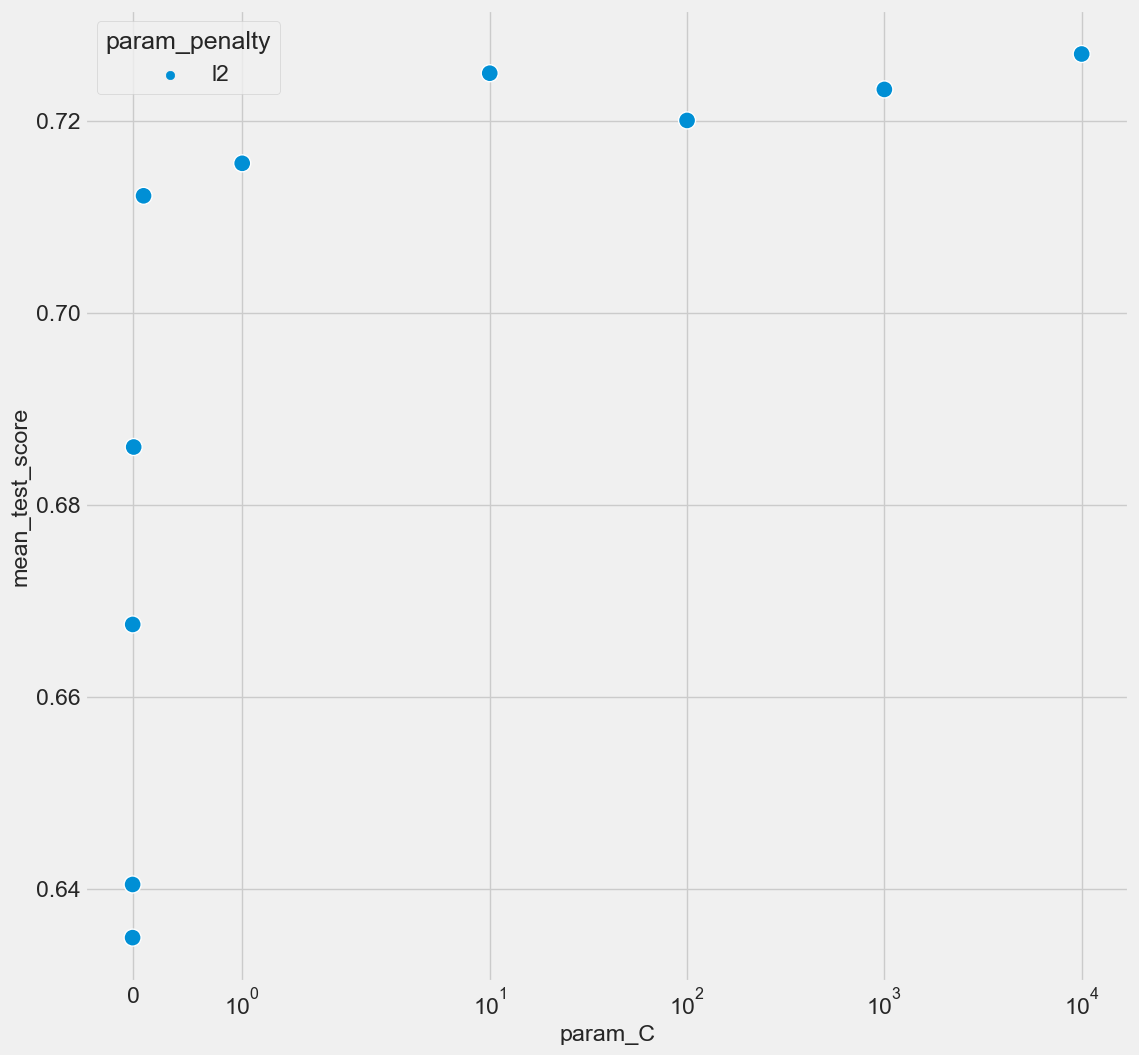

In [464]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(12,12))

sns.scatterplot(x = 'param_C', y = 'mean_test_score', hue = 'param_penalty', data = df[0:10], s=150)

plt.xscale('symlog')
plt.show()

The most successful 10 parametres on a chart.

### RandomizedSearchCV

In [465]:
parametres = {"C": [10 ** x for x in range (-5, 5, 1)],
                "penalty": ['l1', 'l2']
                }

In [466]:
rs_cv = RandomizedSearchCV(estimator=logreg,
                           param_distributions = parametres,
                           cv = 10,
                           n_iter = 10,
                           random_state = 111,
                           scoring = 'precision'
                      )
rs_cv.fit(X, y)

RandomizedSearchCV(cv=10, estimator=LogisticRegression(),
                   param_distributions={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1,
                                              1, 10, 100, 1000, 10000],
                                        'penalty': ['l1', 'l2']},
                   random_state=111, scoring='precision')

In [467]:
print("The Best Parametres: ", rs_cv.best_params_)
print("All Precisions Values: ", rs_cv.cv_results_['mean_test_score'])
print("The Best Precision Value: ", rs_cv.best_score_)

The Best Parametres:  {'penalty': 'l2', 'C': 10}
All Precisions Values:  [0.64245856 0.69113735 0.77055733 0.75968582        nan 0.76488606
        nan        nan        nan        nan]
The Best Precision Value:  0.7705573342003843


In [468]:
results_rs = rs_cv.cv_results_
df_rs = pd.DataFrame(results_rs)

In [469]:
results_rs = rs_cv.cv_results_
df_rs = pd.DataFrame(results_rs)
df_rs = df_rs[['param_penalty','param_C', 'mean_test_score']]
df_rs = df_rs.sort_values(by='mean_test_score', ascending = False)
df_rs

,param_penalty,param_C,mean_test_score
2,l2,10,0.770557
5,l2,1000,0.764886
3,l2,1,0.759686
1,l2,0.001,0.691137
0,l2,0.0001,0.642459
4,l1,100,NaN
6,l1,0.01,NaN
7,l1,0.001,NaN
8,l1,1000,NaN
9,l1,0.00001,NaN


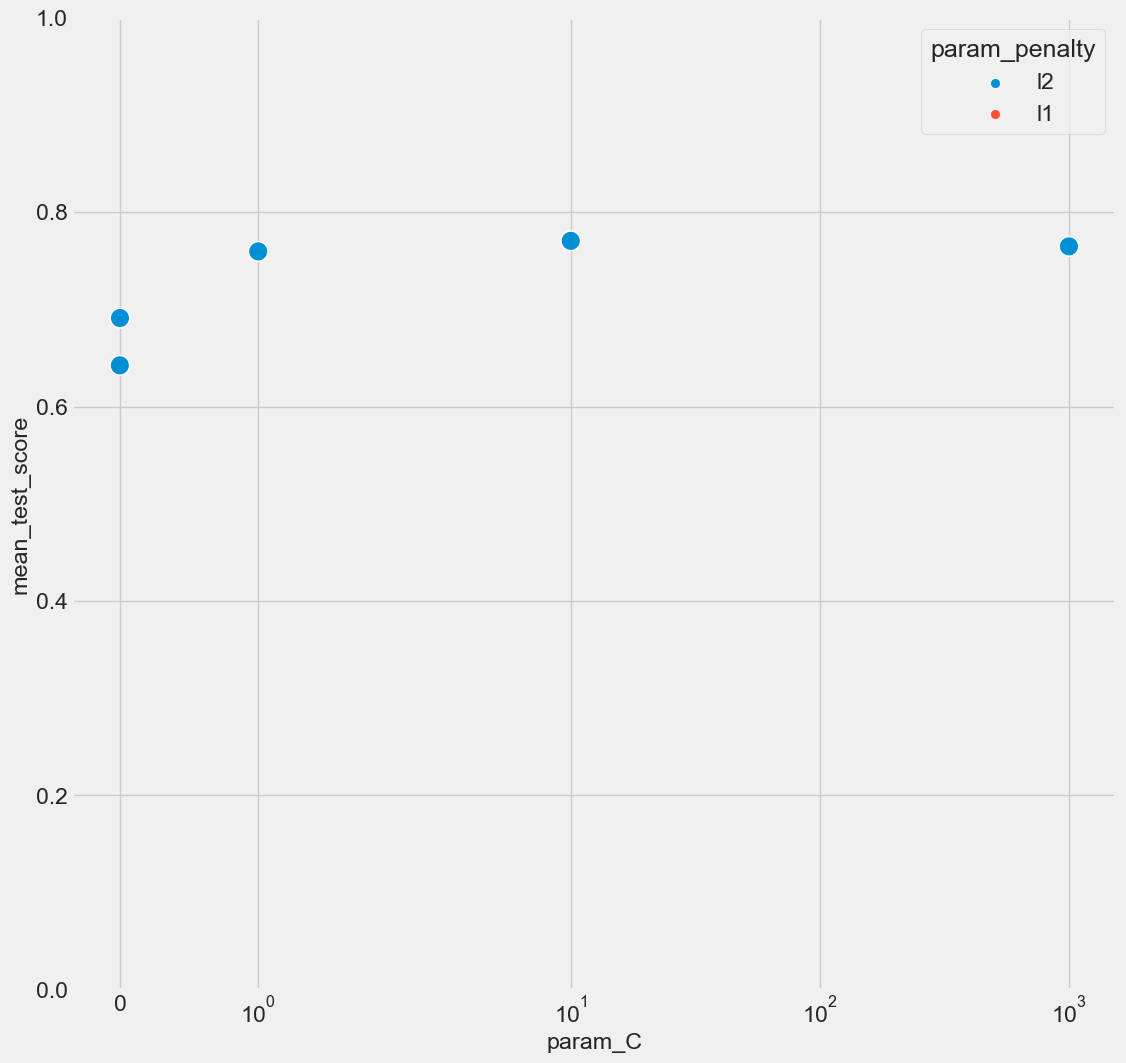

In [470]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,12))
sns.scatterplot(x = 'param_C', y = 'mean_test_score', hue = 'param_penalty', data = df_rs, s=200)
plt.xscale('symlog')
plt.ylim((0.0,1))
plt.show()